## Lepto-philic

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

import particle.literals

import pandas as pd

In [2]:
me = particle.literals.e_minus.mass/1000
mmu = particle.literals.mu_minus.mass/1000
mtau = particle.literals.tau_minus.mass/1000
mUpsilon = particle.literals.Upsilon_1S.mass/1000
widthUpsilon = particle.literals.Upsilon_1S.width/1000
mUpsilon2S = particle.literals.Upsilon_2S.mass/1000
widthUpsilon2S = particle.literals.Upsilon_2S.width/1000
mUpsilon3S = particle.literals.Upsilon_3S.mass/1000
widthUpsilon3S = particle.literals.Upsilon_3S.width/1000
mUpsilon4S = particle.literals.Upsilon_4S.mass/1000
widthUpsilon4S = particle.literals.Upsilon_4S.width/1000
mJpsi = particle.literals.Jpsi_1S.mass/1000
widthJpsi = particle.literals.Jpsi_1S.width/1000
alpha_em = 1/137
fUpsilon = 0.659
fUpsilon2S = 0.481
fUpsilon3S = 0.405
fJpsi = 0.4104 # 2005.01845

fa = 1000

In [3]:
corr_Jpsi = 0.92
corr_2S = 0.21
corr_3S = 0.16
corr_4S = 3e-5

In [4]:
def Cgammagamma(ma, mlep, cgg0=0):
    def f(x):
        if x >= 1:
            return np.arcsin(x**-0.5)
        else:
            return np.pi/2+0.5j*np.log((1+(1-x)**0.5)/(1-(1-x)**0.5))
    B1 = lambda x: 1-x*f(x)**2
    c = cgg0
    for m in mlep:
        c += B1(4*m**2/ma**2)
    return -c*alpha_em/np.pi

In [5]:
Cgammagamma(4, [mtau])

(0.001750264152882719+0.0028579800861611116j)

In [6]:
def Gamma_phi(mphi: float, cgg0=0) -> list[float]:
    def f(x):
        if x >= 1:
            return np.arcsin(x**-0.5)
        else:
            return np.pi/2+0.5j*np.log((1+(1-x)**0.5)/(1-(1-x)**0.5))
    B1 = lambda x: 1-x*f(x)**2
    res = [alpha_em**2*mphi**3/(fa**2*(4*np.pi)**3)*abs(cgg0+B1(4*mtau**2/mphi**2)+B1(4*me**2/mphi**2)+B1(4*mmu**2/mphi**2))**2, 0, 0, 0]
    #res = [4*np.pi*a_em**2/Lambda**2*mphi**3*abs(B1(4*mtau**2/mphi**2)+0*B1(4*mmu**2/mphi**2)+0*B1(4*me**2/mphi**2))**2/(16*np.pi)**2, 0, 0, 0]
    if mphi > 2*me:
        res[1] = mphi * me**2/(8*np.pi*fa**2)*np.sqrt(1-4*me**2/mphi**2)
    if mphi > 2*mmu:
        res[2] = mphi * mmu**2/(8*np.pi*fa**2)*np.sqrt(1-4*mmu**2/mphi**2)
    if mphi > 2*mtau:
        res[3] = mphi * mtau**2/(8*np.pi*fa**2)*np.sqrt(1-4*mtau**2/mphi**2)
    return res

def BR_gg(ma, cgg0=0):
    gamma = Gamma_phi(ma, cgg0)
    return gamma[0]/sum(gamma)

def BR_ee(ma, cgg0=0):
    gamma = Gamma_phi(ma, cgg)
    return gamma[1]/sum(gamma)

def BR_mumu(ma, cgg0=0):
    gamma = Gamma_phi(ma, cgg0)
    return gamma[2]/sum(gamma)

def BR_tautau(ma, cgg0=0):
    gamma = Gamma_phi(ma, cgg0)
    return gamma[3]/sum(gamma)

In [7]:
def BR_Upsilon_gammaAlp(ma, cgg0=0):
    return alpha_em/(216*widthUpsilon)*mUpsilon*fUpsilon**2/fa**2*abs(Cgammagamma(ma, [me, mmu, mtau], cgg0))**2*(1-ma**2/mUpsilon**2)**3

In [8]:
def BR_Upsilon2S_gammaAlp(ma, cgg0=0):
    return alpha_em/(216*widthUpsilon2S)*mUpsilon2S*fUpsilon2S**2/fa**2*abs(Cgammagamma(ma, [me, mmu, mtau], cgg0))**2*(1-ma**2/mUpsilon2S**2)**3

def BR_Upsilon3S_gammaAlp(ma, cgg0=0):
    return alpha_em/(216*widthUpsilon3S)*mUpsilon3S*fUpsilon3S**2/fa**2*abs(Cgammagamma(ma, [me, mmu, mtau], cgg0))**2*(1-ma**2/mUpsilon3S**2)**3

In [9]:
def BR_Jpsi_gammaAlp(ma, cgg0=0):
    return 4*alpha_em/(216*widthJpsi)*mJpsi*fJpsi**2/fa**2*abs(Cgammagamma(ma, [me, mmu, mtau], cgg0))**2*(1-ma**2/mJpsi**2)**3

In [10]:
ma_list = [10**x for x in np.linspace(-3, np.log10(mUpsilon3S), 200)]
BR_list = [BR_Upsilon_gammaAlp(m) for m in ma_list]
BR3S_list = [BR_Upsilon3S_gammaAlp(m) for m in ma_list]

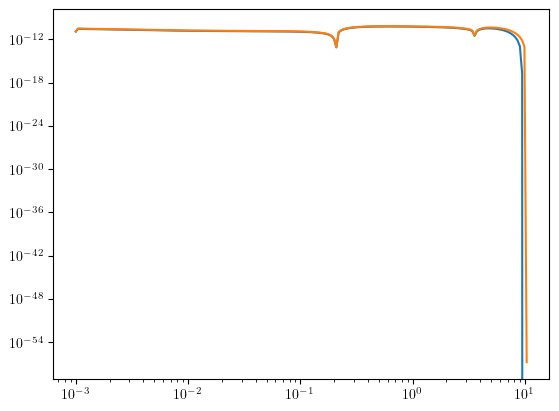

In [11]:
plt.loglog(ma_list, BR_list)
plt.loglog(ma_list, BR3S_list)

In [12]:
(1.5e-4/BR_Upsilon_gammaAlp(4.03))**0.5

2416.7823179616357

In [13]:
Belle_tautau = pd.read_csv('Belle_Upsilon_tautau.csv')
BaBar_tautau = pd.read_csv('BaBar_Upsilon_tautau.csv')
BaBar_Upsilon3S = pd.read_csv('BaBar_Upsilon3S.csv').sort_values(by='x')
BaBar_Upsilon3S = BaBar_Upsilon3S.loc[BaBar_Upsilon3S[' y'] != 0]
Belle_mumu = pd.read_csv('Belle_Upsilon1S_mumu.csv').sort_values(by='x')
BESIII_Jpsi = pd.read_csv('BESIII_Jpsi.csv').sort_values(by='ma_GeV')
BaBar_Upsilon1S_mumu = pd.read_csv('BaBar_Upsilon1S_mumu.csv')
BaBar_Upsilon2S_mumu = pd.read_csv('BaBar_Upsilon2S_mumu.csv')
BaBar_Upsilon3S_mumu = pd.read_csv('BaBar_Upsilon3S_mumu.csv')

BESIII_photons = pd.read_csv('bes3_photons.txt', sep='\t')
BelleII_photons = pd.read_csv('belle2_photons.txt', sep='\t')

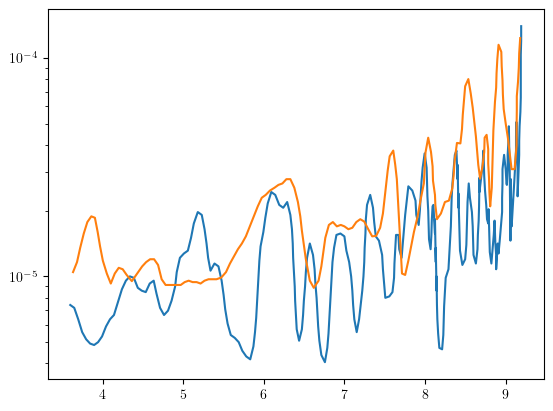

In [14]:
plt.semilogy(Belle_tautau['x'], Belle_tautau[' y'])
plt.semilogy(BaBar_tautau['x'], BaBar_tautau[' y'])

In [15]:
limits_Belle_tau = [(Belle_tautau[' y'][i]/(BR_Upsilon_gammaAlp(Belle_tautau['x'][i])*BR_tautau(Belle_tautau['x'][i])))**0.5 for i in range(len(Belle_tautau['x']))]
limits_BaBar_tau = [(BaBar_tautau[' y'][i]/(BR_Upsilon_gammaAlp(BaBar_tautau['x'][i])*BR_tautau(BaBar_tautau['x'][i])))**0.5 for i in range(len(BaBar_tautau['x']))]
limits_Belle_mu = [(Belle_mumu[' y'][i]*2/1.644/(BR_Upsilon_gammaAlp(Belle_mumu['x'][i])*BR_mumu(Belle_mumu['x'][i])))**0.5 for i in range(len(Belle_mumu['x']))]
limits_BaBar_3S = [(BaBar_Upsilon3S[' y'][i]/(BR_tautau(BaBar_Upsilon3S['x'][i])*BR_Upsilon_gammaAlp(BaBar_Upsilon3S['x'][i])*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
limits_BESIII_Jpsi = [(BESIII_Jpsi['BR'][i]/(BR_Jpsi_gammaAlp(BESIII_Jpsi['ma_GeV'][i])*BR_mumu(BESIII_Jpsi['ma_GeV'][i])*(1+1/corr_Jpsi)))**0.5 for i in range(len(BESIII_Jpsi['ma_GeV']))]
limits_BaBar1S_mu = [(BaBar_Upsilon1S_mumu['BR'][i]*2/1.644/(BR_Upsilon_gammaAlp(BaBar_Upsilon1S_mumu['ma_GeV'][i])*BR_mumu(BaBar_Upsilon1S_mumu['ma_GeV'][i])))**0.5 for i in range(len(BaBar_Upsilon1S_mumu['ma_GeV']))]
limits_BaBar2S_mu = [(BaBar_Upsilon2S_mumu['BR'][i]*2/1.644/(BR_Upsilon2S_gammaAlp(BaBar_Upsilon2S_mumu['ma_GeV'][i])*BR_mumu(BaBar_Upsilon2S_mumu['ma_GeV'][i])*(1+1/corr_2S)))**0.5 for i in range(len(BaBar_Upsilon2S_mumu['ma_GeV']))]
limits_BaBar3S_mu = [(BaBar_Upsilon3S_mumu['BR'][i]*2/1.644/(BR_Upsilon3S_gammaAlp(BaBar_Upsilon3S_mumu['ma_GeV'][i])*BR_mumu(BaBar_Upsilon3S_mumu['ma_GeV'][i])*(1+1/corr_3S)))**0.5 for i in range(len(BaBar_Upsilon3S_mumu['ma_GeV']))]
ma_3S = []
c_3S = []
for i in range(len(limits_BaBar_3S)):
    if np.imag(limits_BaBar_3S[i]) != 0:
        limits_BaBar_3S[i] = float('nan')
        
for i in range(len(limits_BESIII_Jpsi)):
    if np.real(limits_BESIII_Jpsi[i]) == 0:
        limits_BESIII_Jpsi[i] = float('nan')

limits_BESIII_photons = [abs(BESIII_photons['UL_gagg'][i] * fa / Cgammagamma(BESIII_photons['m_a'][i], [me, mmu, mtau])/BR_gg(BESIII_photons['m_a'][i])**0.5) for i in BESIII_photons.index]
limits_BelleII_photons = [abs(BelleII_photons['UL_gagg'][i] * fa / Cgammagamma(BelleII_photons['ALPmass'][i], [me, mmu, mtau])/BR_gg(BelleII_photons['ALPmass'][i])**0.5) for i in BelleII_photons.index] 

/tmp/ipykernel_17709/11659661.py:4: RuntimeWarning: invalid value encountered in scalar power
  limits_BaBar_3S = [(BaBar_Upsilon3S[' y'][i]/(BR_tautau(BaBar_Upsilon3S['x'][i])*BR_Upsilon_gammaAlp(BaBar_Upsilon3S['x'][i])*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
/tmp/ipykernel_17709/11659661.py:5: RuntimeWarning: invalid value encountered in scalar power
  limits_BESIII_Jpsi = [(BESIII_Jpsi['BR'][i]/(BR_Jpsi_gammaAlp(BESIII_Jpsi['ma_GeV'][i])*BR_mumu(BESIII_Jpsi['ma_GeV'][i])*(1+1/corr_Jpsi)))**0.5 for i in range(len(BESIII_Jpsi['ma_GeV']))]


In [16]:
pd.DataFrame({'ma_GeV': Belle_tautau['x'], 'cl': limits_Belle_tau}).to_csv('../data/quarkonia/Belle_Y1Stautau.csv', index=False)
df_BaBar_tautau = pd.DataFrame({'ma_GeV': BaBar_tautau['x'], 'cl': limits_BaBar_tau})
df_BaBar_tautau.to_csv('../data/quarkonia/BaBar_Y1Stautau.csv', index=False)
pd.DataFrame({'ma_GeV': BaBar_Upsilon3S['x'], 'cl': limits_BaBar_3S}).to_csv('../data/quarkonia/BaBar_Y3Stautau.csv', index=False)
pd.DataFrame({'ma_GeV': Belle_mumu['x'], 'cl': limits_Belle_mu}).to_csv('../data/quarkonia/Belle_Y1Smumu.csv', index=False)
pd.DataFrame({'ma_GeV': BaBar_Upsilon1S_mumu['ma_GeV'], 'cl': limits_BaBar1S_mu}).to_csv('../data/quarkonia/BaBar_Y1Smumu.csv', index=False)
pd.DataFrame({'ma_GeV': BaBar_Upsilon2S_mumu['ma_GeV'], 'cl': limits_BaBar2S_mu}).to_csv('../data/quarkonia/BaBar_Y2Smumu.csv', index=False)
df_BaBar_3Smu = pd.DataFrame({'ma_GeV': BaBar_Upsilon3S_mumu['ma_GeV'], 'cl': limits_BaBar3S_mu})
df_BaBar_3Smu.to_csv('../data/quarkonia/BaBar_Y3Smumu.csv', index=False)
pd.DataFrame({'ma_GeV': BESIII_Jpsi['ma_GeV'], 'cl': limits_BESIII_Jpsi}).to_csv('../data/quarkonia/BESIII_Jpsimumu.csv', index=False)

df_3S = pd.concat([df_BaBar_3Smu.loc[df_BaBar_3Smu['ma_GeV'] < df_BaBar_tautau['ma_GeV'][0] ], pd.DataFrame({'ma_GeV': BaBar_Upsilon3S['x'], 'cl': limits_BaBar_3S}) ], ignore_index=True)
df_3S.to_csv('../data/quarkonia/BaBar_Y3S_tot.csv', index=False)
pd.DataFrame({'ma_GeV': BESIII_photons['m_a'], 'cl': limits_BESIII_photons}).to_csv('../data/quarkonia/BESIII_Jpsi3g_lfu.csv', index=False)
pd.DataFrame({'ma_GeV': BelleII_photons['ALPmass'], 'cl': limits_BelleII_photons}).to_csv('../data/quarkonia/BelleII_Y4S3g_lfu.csv', index=False)

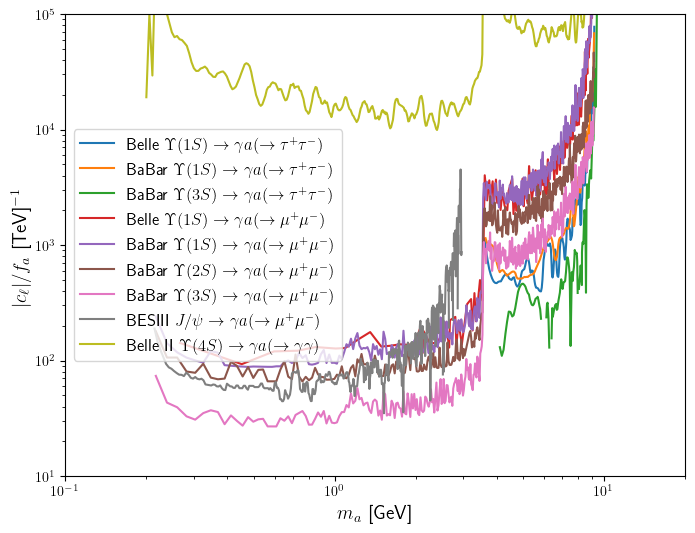

In [17]:
plt.figure(figsize=(8, 6))
plt.loglog(Belle_tautau['x'], limits_Belle_tau, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_tautau['x'], limits_BaBar_tau, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_Upsilon3S['x'], limits_BaBar_3S, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(Belle_mumu['x'], limits_Belle_mu, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BaBar_Upsilon1S_mumu['ma_GeV'], limits_BaBar1S_mu, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BaBar_Upsilon2S_mumu['ma_GeV'], limits_BaBar2S_mu, label=r'BaBar $\Upsilon(2S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BaBar_Upsilon3S_mumu['ma_GeV'], limits_BaBar3S_mu, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BESIII_Jpsi['ma_GeV'], limits_BESIII_Jpsi, label=r'BESIII $J/\psi\to \gamma a(\to \mu^+\mu^-)$')
#plt.loglog(BESIII_photons['m_a'], limits_BESIII_photons, label=r'BESIII $J/\psi \to \gamma a(\to\gamma\gamma)$')
plt.loglog(BelleII_photons['ALPmass'], limits_BelleII_photons, label=r'Belle II $\Upsilon(4S) \to \gamma a(\to\gamma\gamma)$')
plt.xlim(1e-1, 20)
plt.ylim(1e1, 1e5)
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)
plt.ylabel(r'$|c_{\ell}|/f_a$ [TeV]$^{-1}$', fontsize=14)
plt.legend(fontsize=12)
plt.savefig('quarkonia.png')

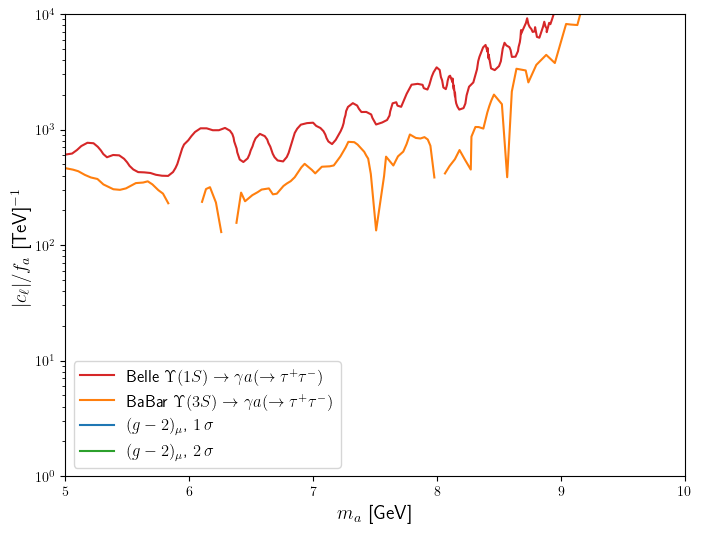

In [18]:
g2data = pd.read_csv('../g2/amu_sigma.csv')

plt.figure(figsize=(8, 6))
plt.semilogy(Belle_tautau['x'], limits_Belle_tau, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$', c='tab:red')
#plt.semilogy(BaBar_tautau['x'], limits_BaBar_tau, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.semilogy(BaBar_Upsilon3S['x'], limits_BaBar_3S, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \tau^+\tau^-)$', c='tab:orange')
#plt.semilogy(Belle_mumu['x'], limits_Belle_mu, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \mu^+\mu^-)$')
#plt.semilogy(BaBar_Upsilon1S_mumu['ma_GeV'], limits_BaBar1S_mu, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \mu^+\mu^-)$')
#plt.semilogy(BaBar_Upsilon2S_mumu['ma_GeV'], limits_BaBar2S_mu, label=r'BaBar $\Upsilon(2S)\to \gamma a(\to \mu^+\mu^-)$')
#plt.semilogy(BaBar_Upsilon3S_mumu['ma_GeV'], limits_BaBar3S_mu, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \mu^+\mu^-)$')
#plt.semilogy(BESIII_Jpsi['ma_GeV'], limits_BESIII_Jpsi, label=r'BESIII $J/\psi\to \gamma a(\to \mu^+\mu^-)$')
plt.semilogy(g2data['ma_GeV'], g2data['cl_1s+'], c='tab:blue', label = r'$(g-2)_\mu$, $1\,\sigma$')
plt.semilogy(g2data['ma_GeV'], g2data['cl_1s-'], c='tab:blue')
plt.semilogy(g2data['ma_GeV'], g2data['cl_2s+'], c='tab:green', label = r'$(g-2)_\mu$, $2\,\sigma$')
plt.semilogy(g2data['ma_GeV'], g2data['cl_2s-'], c='tab:green')
plt.fill_between(g2data['ma_GeV'], g2data['cl_2s-'], g2data['cl_2s+'], color='tab:green', alpha=0.2)
plt.fill_between(g2data['ma_GeV'], g2data['cl_1s-'], g2data['cl_1s+'], color='tab:blue', alpha=0.2)
plt.xlim(5, 10)
plt.ylim(1, 1e4)
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)
plt.ylabel(r'$|c_{\ell}|/f_a$ [TeV]$^{-1}$', fontsize=14)
plt.legend(fontsize=12)

plt.savefig('g2mu_quarkonia.png')

## $\tau$-philic

In [19]:
def Gamma_phi_tp(mphi: float, cgg0=0) -> list[float]:
    def f(x):
        if x >= 1:
            return np.arcsin(x**-0.5)
        else:
            return np.pi/2+0.5j*np.log((1+(1-x)**0.5)/(1-(1-x)**0.5))
    B1 = lambda x: 1-x*f(x)**2
    res = [alpha_em**2*mphi**3/(fa**2*(4*np.pi)**3)*abs(cgg0+B1(4*mtau**2/mphi**2))**2, 0]
    #res = [4*np.pi*a_em**2/Lambda**2*mphi**3*abs(B1(4*mtau**2/mphi**2)+0*B1(4*mmu**2/mphi**2)+0*B1(4*me**2/mphi**2))**2/(16*np.pi)**2, 0, 0, 0]
    if mphi > 2*mtau:
        res[1] = mphi * mtau**2/(8*np.pi*fa**2)*np.sqrt(1-4*mtau**2/mphi**2)
    return res

def BR_gg_tp(ma, cgg0=0):
    gamma = Gamma_phi_tp(ma, cgg0)
    return gamma[0]/sum(gamma)

def BR_tautau_tp(ma, cgg0=0):
    gamma = Gamma_phi_tp(ma, cgg0)
    return gamma[1]/sum(gamma)

In [20]:
def BR_Upsilon_gammaAlp_tp(ma, cgg0=0):
    return alpha_em/(216*widthUpsilon)*mUpsilon*fUpsilon**2/fa**2*abs(Cgammagamma(ma, [mtau], cgg0))**2*(1-ma**2/mUpsilon**2)**3

In [21]:
def BR_Upsilon3S_gammaAlp_tp(ma, cgg0=0):
    return alpha_em/(216*widthUpsilon3S)*mUpsilon3S*fUpsilon3S**2/fa**2*abs(Cgammagamma(ma, [mtau], cgg0))**2*(1-ma**2/mUpsilon3S**2)**3

In [22]:
def BR_Jpsi_gammaAlp_tp(ma, cgg0=0):
    return 4*alpha_em/(216*widthJpsi)*mJpsi*fJpsi**2/fa**2*abs(Cgammagamma(ma, [mtau], cgg0))**2*(1-ma**2/mJpsi**2)**3

In [23]:
BaBar_inv = pd.read_csv('BaBar_inv.csv') #1007.4646
BaBar_inv = BaBar_inv.loc[BaBar_inv['ma_GeV'] < 2*mtau]
Belle_inv = pd.read_csv('Belle_inv.csv') #1809.05222
Belle_inv = Belle_inv.loc[Belle_inv['ma_GeV'] < 2*mtau]
BESIII_inv = pd.read_csv('BESIII_inv.csv') #1007.4646
BaBar_3S_inv = pd.read_csv('BaBar_Upsilon3S_inv.csv')

In [24]:
BelleII_photons.head()

,ALPmass,UL_xsec,UL_gagg
0,0.200000,0.141101,0.001092
1,0.205279,0.154315,0.001142
2,0.210593,0.175059,0.001217
3,0.215941,0.180889,0.001237
4,0.221323,0.180763,0.001236


In [25]:
hbarc = 1.973269804e-10 # GeV μm

limits_Belle_tau = [(Belle_tautau[' y'][i]*2/1.644/(BR_Upsilon_gammaAlp_tp(Belle_tautau['x'][i])*BR_tautau_tp(Belle_tautau['x'][i])))**0.5 for i in range(len(Belle_tautau['x']))]
limits_BaBar_tau = [(BaBar_tautau[' y'][i]*2/1.644/(BR_Upsilon_gammaAlp_tp(BaBar_tautau['x'][i])*BR_tautau_tp(BaBar_tautau['x'][i])))**0.5 for i in range(len(BaBar_tautau['x']))]
limits_BaBar_3S = [(BaBar_Upsilon3S[' y'][i]*2/1.644/(BR_tautau_tp(BaBar_Upsilon3S['x'][i])*BR_Upsilon_gammaAlp_tp(BaBar_Upsilon3S['x'][i])*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
c_3S = []
for i in range(len(limits_BaBar_3S)):
    if np.imag(limits_BaBar_3S[i]) != 0:
        limits_BaBar_3S[i] = float('nan')
limits_BaBar_inv = [(BaBar_inv['BR_inv'][i]/BR_Upsilon_gammaAlp_tp(BaBar_inv['ma_GeV'][i]))**0.5 for i in range(len(BaBar_inv['ma_GeV']))]
for i, (m, c) in enumerate(zip(BaBar_inv['ma_GeV'], limits_BaBar_inv)):
    if hbarc/(c**2*sum(Gamma_phi_tp(m)))*1e-6 < 3:
        limits_BaBar_inv[i] = float('nan')
limits_Belle_inv = [(Belle_inv['BR_inv'][i]/BR_Upsilon_gammaAlp_tp(Belle_inv['ma_GeV'][i]))**0.5 for i in range(len(Belle_inv['ma_GeV']))]
for i, (m, c) in enumerate(zip(Belle_inv['ma_GeV'], limits_Belle_inv)):
    if i > 0 and hbarc/(c**2*sum(Gamma_phi_tp(m)))*1e-6 < 3:
        limits_Belle_inv[i] = float('nan')
limits_BESIII_inv = [(BESIII_inv['BR_inv'][i]/BR_Jpsi_gammaAlp_tp(BESIII_inv['ma_GeV'][i]))**0.5 for i in range(len(BESIII_inv['ma_GeV']))]
for i, (m, c) in enumerate(zip(BESIII_inv['ma_GeV'], limits_BESIII_inv)):
    if hbarc/(c**2*sum(Gamma_phi_tp(m)))*1e-6 < 3:
        limits_BESIII_inv[i] = float('nan')

limits_BESIII_photons_tp = [BESIII_photons['UL_gagg'][i] * fa / Cgammagamma(BESIII_photons['m_a'][i], [mtau]) for i in BESIII_photons.index]
limits_BelleII_photons_tp = [abs(BelleII_photons['UL_gagg'][i] * fa / Cgammagamma(BelleII_photons['ALPmass'][i], [mtau])/BR_gg_tp(BelleII_photons['ALPmass'][i])**0.5) for i in BelleII_photons.index]
#limits_BelleII_photons = [BelleII_photons['UL_gagg'][i] * fa / Cgammagamma(BelleII_photons['ALPmass'][i], [mtau]) for i in BelleII_photons.index]

/tmp/ipykernel_17709/1789325778.py:5: RuntimeWarning: invalid value encountered in scalar power
  limits_BaBar_3S = [(BaBar_Upsilon3S[' y'][i]*2/1.644/(BR_tautau_tp(BaBar_Upsilon3S['x'][i])*BR_Upsilon_gammaAlp_tp(BaBar_Upsilon3S['x'][i])*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
/tmp/ipykernel_17709/1254838554.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  c += B1(4*m**2/ma**2)
/tmp/ipykernel_17709/1254838554.py:7: RuntimeWarning: invalid value encountered in scalar multiply
  B1 = lambda x: 1-x*f(x)**2


In [26]:
pd.DataFrame({'ma_GeV': BESIII_photons['m_a'], 'cl': limits_BESIII_photons_tp}).to_csv('../data/quarkonia/BESIII_Jpsi3g_tau.csv', index=False)
pd.DataFrame({'ma_GeV': BelleII_photons['ALPmass'], 'cl': limits_BelleII_photons_tp}).to_csv('../data/quarkonia/BelleII_Y4S3g_tau.csv', index=False)

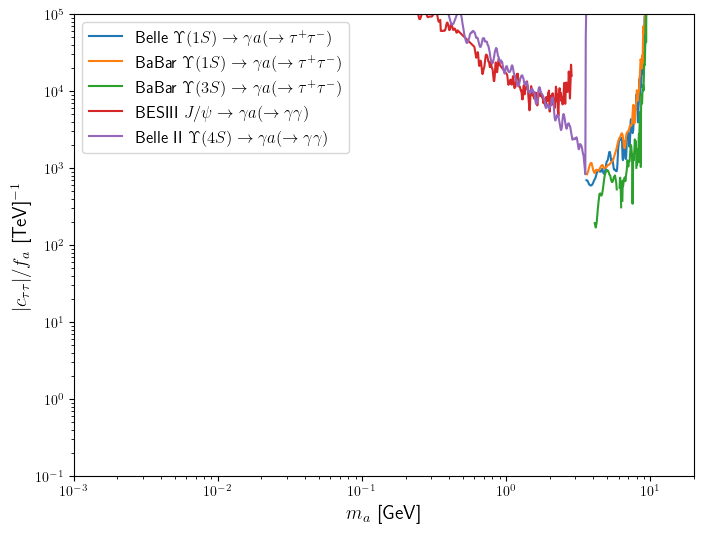

In [27]:
plt.figure(figsize=(8, 6))
plt.loglog(Belle_tautau['x'], limits_Belle_tau, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_tautau['x'], limits_BaBar_tau, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_Upsilon3S['x'], limits_BaBar_3S, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \tau^+\tau^-)$')
#plt.loglog(Belle_inv['ma_GeV'], limits_Belle_inv, label=r'Belle $\Upsilon(1S)\to \gamma + \mathrm{inv}$')
#plt.loglog(BaBar_inv['ma_GeV'], limits_BaBar_inv, label=r'BaBar $\Upsilon(1S)\to \gamma + \mathrm{inv}$')
#plt.loglog(BESIII_inv['ma_GeV'], limits_BESIII_inv, label=r'BESIII $J/\psi\to \gamma + \mathrm{inv}$')
plt.loglog(BESIII_photons['m_a'], limits_BESIII_photons_tp, label=r'BESIII $J/\psi \to \gamma a(\to\gamma\gamma)$')
plt.loglog(BelleII_photons['ALPmass'], limits_BelleII_photons_tp, label=r'Belle II $\Upsilon(4S) \to \gamma a(\to\gamma\gamma)$')
plt.xlim(1e-3, 20)
plt.ylim(1e-1, 1e5)
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)

plt.ylabel(r'$|c_{\tau\tau}|/f_a$ [TeV]$^{-1}$', fontsize=14)
plt.legend(fontsize=12)
plt.savefig('quarkonia_tau.png')

(0.1, 3.5537199999999998)

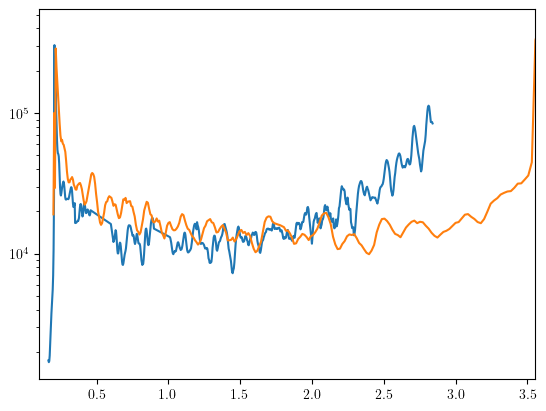

In [28]:
plt.semilogy(BESIII_photons['m_a'], limits_BESIII_photons, label=r'BESIII $J/\psi \to \gamma a(\to\gamma\gamma)$')
plt.semilogy(BelleII_photons['ALPmass'], limits_BelleII_photons, label=r'Belle II $\Upsilon(4S) \to \gamma a(\to\gamma\gamma)$')
plt.xlim(1e-1, 2*mtau)

# Comparison with 2402.12454

In [29]:
def BR_Jpsi_gagg(ma, gagg):
    cgg = np.pi*fa*gagg/alpha_em
    return 4*alpha_em**3/(216*widthJpsi*np.pi**2)*mJpsi*fJpsi**2/fa**2*abs(cgg)**2*(1-ma**2/mJpsi**2)**3

def BR_Upsilon3S_gagg(ma, gagg):
    cgg = np.pi*fa*gagg/alpha_em
    return alpha_em**3/(216*widthUpsilon3S*np.pi**2)*mUpsilon3S*fUpsilon3S**2/fa**2*abs(cgg)**2*(1-ma**2/mUpsilon3S**2)**3

def BR_Upsilon_gagg(ma, gagg):
    cgg = np.pi*fa*gagg/alpha_em
    return alpha_em**3/(216*widthUpsilon*np.pi**2)*mUpsilon*fUpsilon**2/fa**2*abs(cgg)**2*(1-ma**2/mUpsilon**2)**3

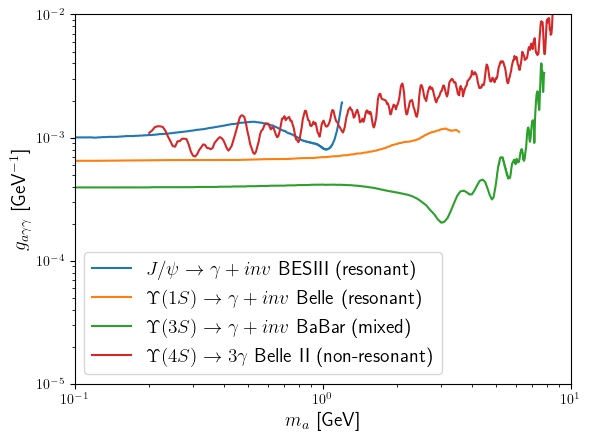

In [30]:
plt.loglog(BESIII_inv['ma_GeV'], [(BESIII_inv['BR_inv'][i]/BR_Jpsi_gagg(BESIII_inv['ma_GeV'][i], 1.0))**0.5 for i in range(len(BESIII_inv['ma_GeV']))], label=r'$J/\psi\to\gamma+inv$ BESIII (resonant)')
plt.loglog(Belle_inv['ma_GeV'], [(Belle_inv['BR_inv'][i]/BR_Upsilon_gagg(Belle_inv['ma_GeV'][i], 1.0))**0.5 for i in range(len(Belle_inv['ma_GeV']))], label=r'$\Upsilon(1S)\to\gamma+inv$ Belle (resonant)')
plt.loglog(BaBar_3S_inv['ma_GeV'], [(BaBar_3S_inv['BR'][i]/(BR_Upsilon3S_gagg(BaBar_3S_inv['ma_GeV'][i], 1.0)*(1+1/0.16)))**0.5 for i in range(len(BaBar_3S_inv['ma_GeV']))], label=r'$\Upsilon(3S)\to\gamma+inv$ BaBar (mixed)')
plt.loglog(BelleII_photons['ALPmass'], BelleII_photons['UL_gagg'], label=r'$\Upsilon(4S)\to 3\gamma$ Belle II (non-resonant)')
plt.xlim([1e-1, 1e1])
plt.ylim([1e-5, 1e-2])
plt.legend(fontsize=14)
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)
plt.ylabel(r'$g_{a\gamma\gamma}$ [GeV$^{-1}$]', fontsize=14)
plt.savefig('quarkonia_mixed.png')

# UV coupling to photons

## LFU

In [31]:
limits_Belle_tau_gg5p = [(Belle_tautau[' y'][i]/(BR_Upsilon_gammaAlp(Belle_tautau['x'][i], 5)*BR_tautau(Belle_tautau['x'][i], 5)))**0.5 for i in range(len(Belle_tautau['x']))]
limits_BaBar_tau_gg5p = [(BaBar_tautau[' y'][i]/(BR_Upsilon_gammaAlp(BaBar_tautau['x'][i], 5)*BR_tautau(BaBar_tautau['x'][i], 5)))**0.5 for i in range(len(BaBar_tautau['x']))]
limits_Belle_mu_gg5p = [(Belle_mumu[' y'][i]/(BR_Upsilon_gammaAlp(Belle_mumu['x'][i], 5)*BR_mumu(Belle_mumu['x'][i], 5)))**0.5 for i in range(len(Belle_mumu['x']))]
limits_BaBar_3S_gg5p = [(BaBar_Upsilon3S[' y'][i]/(BR_tautau(BaBar_Upsilon3S['x'][i], 5)*BR_Upsilon_gammaAlp(BaBar_Upsilon3S['x'][i], 5)*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
limits_BESIII_Jpsi_gg5p = [(BESIII_Jpsi['BR'][i]/(BR_Jpsi_gammaAlp(BESIII_Jpsi['ma_GeV'][i], 5)*BR_mumu(BESIII_Jpsi['ma_GeV'][i], 5)*(1+1/corr_Jpsi)))**0.5 for i in range(len(BESIII_Jpsi['ma_GeV']))]
limits_BaBar1S_mu_gg5p = [(BaBar_Upsilon1S_mumu['BR'][i]/(BR_Upsilon_gammaAlp(BaBar_Upsilon1S_mumu['ma_GeV'][i], 5)*BR_mumu(BaBar_Upsilon1S_mumu['ma_GeV'][i], 5)))**0.5 for i in range(len(BaBar_Upsilon1S_mumu['ma_GeV']))]
limits_BaBar2S_mu_gg5p = [(BaBar_Upsilon2S_mumu['BR'][i]/(BR_Upsilon2S_gammaAlp(BaBar_Upsilon2S_mumu['ma_GeV'][i], 5)*BR_mumu(BaBar_Upsilon2S_mumu['ma_GeV'][i], 5)*(1+1/corr_2S)))**0.5 for i in range(len(BaBar_Upsilon2S_mumu['ma_GeV']))]
limits_BaBar3S_mu_gg5p = [(BaBar_Upsilon3S_mumu['BR'][i]/(BR_Upsilon3S_gammaAlp(BaBar_Upsilon3S_mumu['ma_GeV'][i], 5)*BR_mumu(BaBar_Upsilon3S_mumu['ma_GeV'][i], 5)*(1+1/corr_3S)))**0.5 for i in range(len(BaBar_Upsilon3S_mumu['ma_GeV']))]
ma_3S_gg5p = []
c_3S_gg5p = []
for i in range(len(limits_BaBar_3S_gg5p)):
    if np.imag(limits_BaBar_3S_gg5p[i]) != 0:
        limits_BaBar_3S_gg5p[i] = float('nan')
        
for i in range(len(limits_BESIII_Jpsi_gg5p)):
    if np.real(limits_BESIII_Jpsi_gg5p[i]) == 0:
        limits_BESIII_Jpsi_gg5p[i] = float('nan')

limits_BESIII_photons_gg5p = [abs(BESIII_photons['UL_gagg'][i] * fa / Cgammagamma(BESIII_photons['m_a'][i], [me, mmu, mtau], 5)/BR_gg(BESIII_photons['m_a'][i], 5)**0.5) for i in BESIII_photons.index]
limits_BelleII_photons_gg5p = [abs(BelleII_photons['UL_gagg'][i] * fa / Cgammagamma(BelleII_photons['ALPmass'][i], [me, mmu, mtau], 5)/BR_gg(BelleII_photons['ALPmass'][i], 5)**0.5) for i in BelleII_photons.index] 

/tmp/ipykernel_17709/2000328201.py:4: RuntimeWarning: invalid value encountered in scalar power
  limits_BaBar_3S_gg5p = [(BaBar_Upsilon3S[' y'][i]/(BR_tautau(BaBar_Upsilon3S['x'][i], 5)*BR_Upsilon_gammaAlp(BaBar_Upsilon3S['x'][i], 5)*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
/tmp/ipykernel_17709/2000328201.py:5: RuntimeWarning: invalid value encountered in scalar power
  limits_BESIII_Jpsi_gg5p = [(BESIII_Jpsi['BR'][i]/(BR_Jpsi_gammaAlp(BESIII_Jpsi['ma_GeV'][i], 5)*BR_mumu(BESIII_Jpsi['ma_GeV'][i], 5)*(1+1/corr_Jpsi)))**0.5 for i in range(len(BESIII_Jpsi['ma_GeV']))]


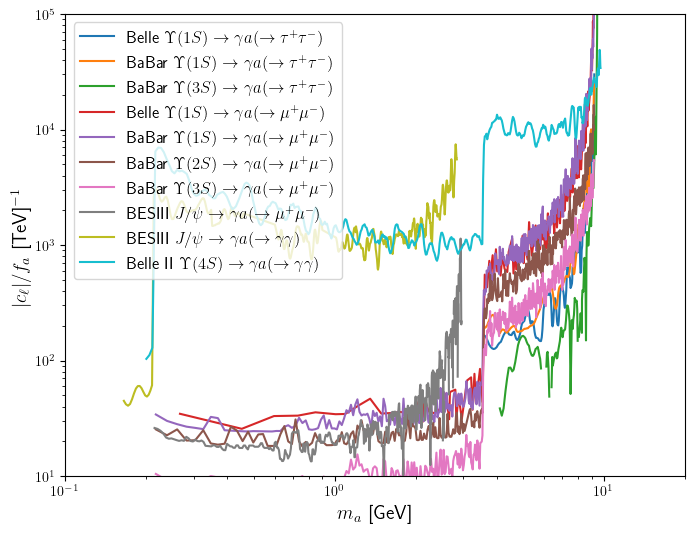

In [32]:
plt.figure(figsize=(8, 6))
plt.loglog(Belle_tautau['x'], limits_Belle_tau_gg5p, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_tautau['x'], limits_BaBar_tau_gg5p, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_Upsilon3S['x'], limits_BaBar_3S_gg5p, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(Belle_mumu['x'], limits_Belle_mu_gg5p, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BaBar_Upsilon1S_mumu['ma_GeV'], limits_BaBar1S_mu_gg5p, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BaBar_Upsilon2S_mumu['ma_GeV'], limits_BaBar2S_mu_gg5p, label=r'BaBar $\Upsilon(2S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BaBar_Upsilon3S_mumu['ma_GeV'], limits_BaBar3S_mu_gg5p, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BESIII_Jpsi['ma_GeV'], limits_BESIII_Jpsi_gg5p, label=r'BESIII $J/\psi\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BESIII_photons['m_a'], limits_BESIII_photons_gg5p, label=r'BESIII $J/\psi \to \gamma a(\to\gamma\gamma)$')
plt.loglog(BelleII_photons['ALPmass'], limits_BelleII_photons_gg5p, label=r'Belle II $\Upsilon(4S) \to \gamma a(\to\gamma\gamma)$')
plt.xlim(1e-1, 20)
plt.ylim(1e1, 1e5)
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)
plt.ylabel(r'$|c_{\ell}|/f_a$ [TeV]$^{-1}$', fontsize=14)
plt.legend(fontsize=12)

In [33]:
limits_Belle_tau_gg5m = [(Belle_tautau[' y'][i]/(BR_Upsilon_gammaAlp(Belle_tautau['x'][i], -5)*BR_tautau(Belle_tautau['x'][i], -5)))**0.5 for i in range(len(Belle_tautau['x']))]
limits_BaBar_tau_gg5m = [(BaBar_tautau[' y'][i]/(BR_Upsilon_gammaAlp(BaBar_tautau['x'][i], -5)*BR_tautau(BaBar_tautau['x'][i], -5)))**0.5 for i in range(len(BaBar_tautau['x']))]
limits_Belle_mu_gg5m = [(Belle_mumu[' y'][i]/(BR_Upsilon_gammaAlp(Belle_mumu['x'][i], -5)*BR_mumu(Belle_mumu['x'][i], -5)))**0.5 for i in range(len(Belle_mumu['x']))]
limits_BaBar_3S_gg5m = [(BaBar_Upsilon3S[' y'][i]/(BR_tautau(BaBar_Upsilon3S['x'][i], -5)*BR_Upsilon_gammaAlp(BaBar_Upsilon3S['x'][i], -5)*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
limits_BESIII_Jpsi_gg5m = [(BESIII_Jpsi['BR'][i]/(BR_Jpsi_gammaAlp(BESIII_Jpsi['ma_GeV'][i], -5)*BR_mumu(BESIII_Jpsi['ma_GeV'][i], -5)*(1+1/corr_Jpsi)))**0.5 for i in range(len(BESIII_Jpsi['ma_GeV']))]
limits_BaBar1S_mu_gg5m = [(BaBar_Upsilon1S_mumu['BR'][i]/(BR_Upsilon_gammaAlp(BaBar_Upsilon1S_mumu['ma_GeV'][i], -5)*BR_mumu(BaBar_Upsilon1S_mumu['ma_GeV'][i], -5)))**0.5 for i in range(len(BaBar_Upsilon1S_mumu['ma_GeV']))]
limits_BaBar2S_mu_gg5m = [(BaBar_Upsilon2S_mumu['BR'][i]/(BR_Upsilon2S_gammaAlp(BaBar_Upsilon2S_mumu['ma_GeV'][i], -5)*BR_mumu(BaBar_Upsilon2S_mumu['ma_GeV'][i], -5)*(1+1/corr_2S)))**0.5 for i in range(len(BaBar_Upsilon2S_mumu['ma_GeV']))]
limits_BaBar3S_mu_gg5m = [(BaBar_Upsilon3S_mumu['BR'][i]/(BR_Upsilon3S_gammaAlp(BaBar_Upsilon3S_mumu['ma_GeV'][i], -5)*BR_mumu(BaBar_Upsilon3S_mumu['ma_GeV'][i], -5)*(1+1/corr_3S)))**0.5 for i in range(len(BaBar_Upsilon3S_mumu['ma_GeV']))]

for i in range(len(limits_BaBar_3S_gg5m)):
    if np.imag(limits_BaBar_3S_gg5m[i]) != 0:
        limits_BaBar_3S_gg5m[i] = float('nan')
        
for i in range(len(limits_BESIII_Jpsi_gg5m)):
    if np.real(limits_BESIII_Jpsi_gg5m[i]) == 0:
        limits_BESIII_Jpsi_gg5m[i] = float('nan')

limits_BESIII_photons_gg5m = [abs(BESIII_photons['UL_gagg'][i] * fa / Cgammagamma(BESIII_photons['m_a'][i], [me, mmu, mtau], -5)/BR_gg(BESIII_photons['m_a'][i], -5)**0.5) for i in BESIII_photons.index]
limits_BelleII_photons_gg5m = [abs(BelleII_photons['UL_gagg'][i] * fa / Cgammagamma(BelleII_photons['ALPmass'][i], [me, mmu, mtau], -5)/BR_gg(BelleII_photons['ALPmass'][i], -5)**0.5) for i in BelleII_photons.index] 

/tmp/ipykernel_17709/394958987.py:4: RuntimeWarning: invalid value encountered in scalar power
  limits_BaBar_3S_gg5m = [(BaBar_Upsilon3S[' y'][i]/(BR_tautau(BaBar_Upsilon3S['x'][i], -5)*BR_Upsilon_gammaAlp(BaBar_Upsilon3S['x'][i], -5)*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
/tmp/ipykernel_17709/394958987.py:5: RuntimeWarning: invalid value encountered in scalar power
  limits_BESIII_Jpsi_gg5m = [(BESIII_Jpsi['BR'][i]/(BR_Jpsi_gammaAlp(BESIII_Jpsi['ma_GeV'][i], -5)*BR_mumu(BESIII_Jpsi['ma_GeV'][i], -5)*(1+1/corr_Jpsi)))**0.5 for i in range(len(BESIII_Jpsi['ma_GeV']))]


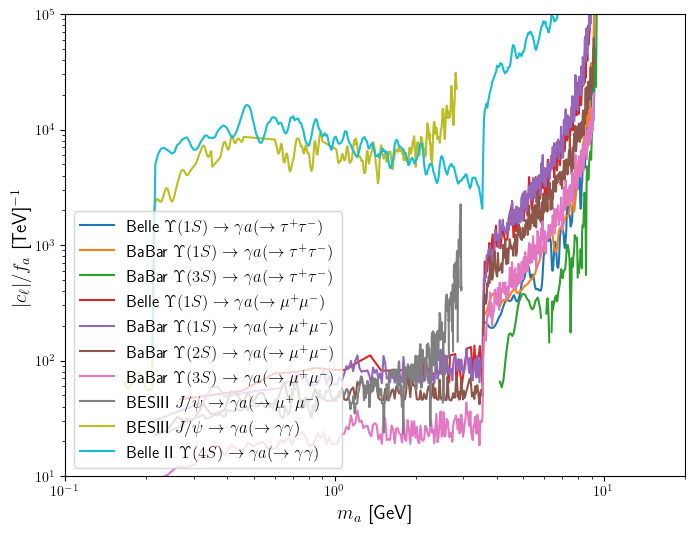

In [34]:
plt.figure(figsize=(8, 6))
plt.loglog(Belle_tautau['x'], limits_Belle_tau_gg5m, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_tautau['x'], limits_BaBar_tau_gg5m, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_Upsilon3S['x'], limits_BaBar_3S_gg5m, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(Belle_mumu['x'], limits_Belle_mu_gg5m, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BaBar_Upsilon1S_mumu['ma_GeV'], limits_BaBar1S_mu_gg5m, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BaBar_Upsilon2S_mumu['ma_GeV'], limits_BaBar2S_mu_gg5m, label=r'BaBar $\Upsilon(2S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BaBar_Upsilon3S_mumu['ma_GeV'], limits_BaBar3S_mu_gg5m, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BESIII_Jpsi['ma_GeV'], limits_BESIII_Jpsi_gg5m, label=r'BESIII $J/\psi\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BESIII_photons['m_a'], limits_BESIII_photons_gg5m, label=r'BESIII $J/\psi \to \gamma a(\to\gamma\gamma)$')
plt.loglog(BelleII_photons['ALPmass'], limits_BelleII_photons_gg5m, label=r'Belle II $\Upsilon(4S) \to \gamma a(\to\gamma\gamma)$')
plt.xlim(1e-1, 20)
plt.ylim(1e1, 1e5)
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)
plt.ylabel(r'$|c_{\ell}|/f_a$ [TeV]$^{-1}$', fontsize=14)
plt.legend(fontsize=12)

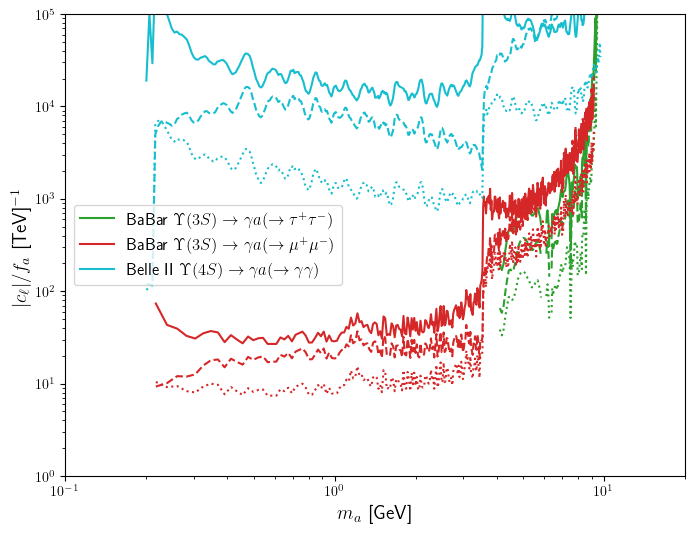

In [35]:
plt.figure(figsize=(8, 6))
#plt.loglog(Belle_tautau['x'], limits_Belle_tau, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
#plt.loglog(BaBar_tautau['x'], limits_BaBar_tau, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_Upsilon3S['x'], limits_BaBar_3S, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \tau^+\tau^-)$', c='tab:green')
plt.loglog(BaBar_Upsilon3S['x'], limits_BaBar_3S_gg5p, ls='dotted', c='tab:green')
plt.loglog(BaBar_Upsilon3S['x'], limits_BaBar_3S_gg5m, ls='dashed', c='tab:green')
#plt.loglog(Belle_mumu['x'], limits_Belle_mu, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \mu^+\mu^-)$')
#plt.loglog(BaBar_Upsilon1S_mumu['ma_GeV'], limits_BaBar1S_mu, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \mu^+\mu^-)$')
#plt.loglog(BaBar_Upsilon2S_mumu['ma_GeV'], limits_BaBar2S_mu, label=r'BaBar $\Upsilon(2S)\to \gamma a(\to \mu^+\mu^-)$')
plt.loglog(BaBar_Upsilon3S_mumu['ma_GeV'], limits_BaBar3S_mu, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \mu^+\mu^-)$', c='tab:red')
plt.loglog(BaBar_Upsilon3S_mumu['ma_GeV'], limits_BaBar3S_mu_gg5p, ls='dotted', c='tab:red')
plt.loglog(BaBar_Upsilon3S_mumu['ma_GeV'], limits_BaBar3S_mu_gg5m, ls='dashed', c='tab:red')
#plt.loglog(BESIII_Jpsi['ma_GeV'], limits_BESIII_Jpsi, label=r'BESIII $J/\psi\to \gamma a(\to \mu^+\mu^-)$')
#plt.loglog(BESIII_photons['m_a'], limits_BESIII_photons, label=r'BESIII $J/\psi \to \gamma a(\to\gamma\gamma)$')
plt.loglog(BelleII_photons['ALPmass'], limits_BelleII_photons, label=r'Belle II $\Upsilon(4S) \to \gamma a(\to\gamma\gamma)$', c='tab:cyan')
plt.loglog(BelleII_photons['ALPmass'], limits_BelleII_photons_gg5p, ls='dotted', c='tab:cyan')
plt.loglog(BelleII_photons['ALPmass'], limits_BelleII_photons_gg5m, ls='dashed', c='tab:cyan')
plt.xlim(1e-1, 20)
plt.ylim(1, 1e5)
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)
plt.ylabel(r'$|c_{\ell}|/f_a$ [TeV]$^{-1}$', fontsize=14)
plt.legend(fontsize=12)

In [36]:
pd.DataFrame({'ma_GeV': BaBar_Upsilon3S['x'], 'cl+gg0': limits_BaBar_3S_gg5p, 'cl-gg0': limits_BaBar_3S_gg5m, }).to_csv('../data/quarkonia/BaBar_Y3Stautau_cgg.csv', index=False)
pd.DataFrame({'ma_GeV': BaBar_Upsilon3S_mumu['ma_GeV'], 'cl+gg0': limits_BaBar3S_mu_gg5p, 'cl-gg0': limits_BaBar3S_mu_gg5m}).to_csv('../data/quarkonia/BaBar_Y3Smumu_cgg.csv', index=False)
pd.DataFrame({'ma_GeV': BelleII_photons['ALPmass'], 'cl+gg0': limits_BelleII_photons_gg5p, 'cl-gg0': limits_BelleII_photons_gg5m}).to_csv('../data/quarkonia/BelleII_Y4S3g_lfu_cgg.csv', index=False)

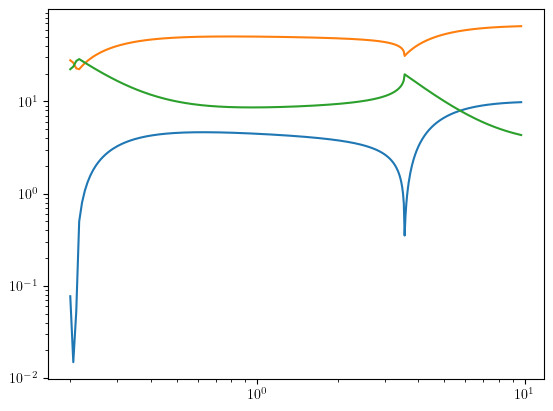

In [37]:
plt.loglog(BelleII_photons['ALPmass'], [abs(np.pi/alpha_em*Cgammagamma(ma, [me, mmu, mtau]))**2 for ma in BelleII_photons['ALPmass']])
plt.loglog(BelleII_photons['ALPmass'], [abs(np.pi/alpha_em*Cgammagamma(ma, [me, mmu, mtau], 5))**2 for ma in BelleII_photons['ALPmass']])
plt.loglog(BelleII_photons['ALPmass'], [abs(np.pi/alpha_em*Cgammagamma(ma, [me, mmu, mtau], -5))**2 for ma in BelleII_photons['ALPmass']]) 

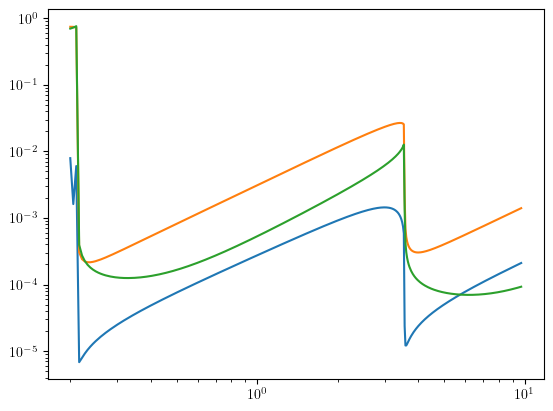

In [38]:
plt.loglog(BelleII_photons['ALPmass'], [BR_gg(ma) for ma in BelleII_photons['ALPmass']])
plt.loglog(BelleII_photons['ALPmass'], [BR_gg(ma, 5) for ma in BelleII_photons['ALPmass']])
plt.loglog(BelleII_photons['ALPmass'], [BR_gg(ma, -5) for ma in BelleII_photons['ALPmass']]) 

## $\tau$-philic

In [39]:
limits_Belle_tau_tp_gg5p = [(Belle_tautau[' y'][i]/(BR_Upsilon_gammaAlp_tp(Belle_tautau['x'][i], 5)*BR_tautau_tp(Belle_tautau['x'][i], 5)))**0.5 for i in range(len(Belle_tautau['x']))]
limits_BaBar_tau_tp_gg5p = [(BaBar_tautau[' y'][i]/(BR_Upsilon_gammaAlp_tp(BaBar_tautau['x'][i], 5)*BR_tautau_tp(BaBar_tautau['x'][i], 5)))**0.5 for i in range(len(BaBar_tautau['x']))]
limits_BaBar_3S_tp_gg5p = [(BaBar_Upsilon3S[' y'][i]/(BR_tautau_tp(BaBar_Upsilon3S['x'][i], 5)*BR_Upsilon_gammaAlp_tp(BaBar_Upsilon3S['x'][i], 5)*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
c_3S = []
for i in range(len(limits_BaBar_3S_gg5p)):
    if np.imag(limits_BaBar_3S_gg5p[i]) != 0:
        limits_BaBar_3S_gg5p[i] = float('nan')
limits_BaBar_inv_gg5p = [(BaBar_inv['BR_inv'][i]/BR_Upsilon_gammaAlp_tp(BaBar_inv['ma_GeV'][i], 5))**0.5 for i in range(len(BaBar_inv['ma_GeV']))]
for i, (m, c) in enumerate(zip(BaBar_inv['ma_GeV'], limits_BaBar_inv_gg5p)):
    if hbarc/(c**2*sum(Gamma_phi_tp(m, 5)))*1e-6 < 3:
        limits_BaBar_inv_gg5p[i] = float('nan')
limits_Belle_inv_gg5p = [(Belle_inv['BR_inv'][i]/BR_Upsilon_gammaAlp_tp(Belle_inv['ma_GeV'][i], 5))**0.5 for i in range(len(Belle_inv['ma_GeV']))]
for i, (m, c) in enumerate(zip(Belle_inv['ma_GeV'], limits_Belle_inv_gg5p)):
    if i > 0 and hbarc/(c**2*sum(Gamma_phi_tp(m, 5)))*1e-6 < 3:
        limits_Belle_inv_gg5p[i] = float('nan')
limits_BESIII_inv_gg5p = [(BESIII_inv['BR_inv'][i]/BR_Jpsi_gammaAlp_tp(BESIII_inv['ma_GeV'][i], 5))**0.5 for i in range(len(BESIII_inv['ma_GeV']))]
for i, (m, c) in enumerate(zip(BESIII_inv['ma_GeV'], limits_BESIII_inv_gg5p)):
    if hbarc/(c**2*sum(Gamma_phi_tp(m,5)))*1e-6 < 3:
        limits_BESIII_inv_gg5p[i] = float('nan')

limits_BESIII_photons_tp_gg5p = [abs(BESIII_photons['UL_gagg'][i] * fa / Cgammagamma(BESIII_photons['m_a'][i], [mtau], 5)/BR_gg_tp(BESIII_photons['m_a'][i], 5)**0.5) for i in BESIII_photons.index]
limits_BelleII_photons_tp_gg5p = [abs(BelleII_photons['UL_gagg'][i] * fa / Cgammagamma(BelleII_photons['ALPmass'][i], [mtau], 5)/BR_gg_tp(BelleII_photons['ALPmass'][i], 5)**0.5) for i in BelleII_photons.index]

/tmp/ipykernel_17709/759930607.py:3: RuntimeWarning: invalid value encountered in scalar power
  limits_BaBar_3S_tp_gg5p = [(BaBar_Upsilon3S[' y'][i]/(BR_tautau_tp(BaBar_Upsilon3S['x'][i], 5)*BR_Upsilon_gammaAlp_tp(BaBar_Upsilon3S['x'][i], 5)*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
/tmp/ipykernel_17709/1254838554.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  c += B1(4*m**2/ma**2)
/tmp/ipykernel_17709/1254838554.py:7: RuntimeWarning: invalid value encountered in scalar multiply
  B1 = lambda x: 1-x*f(x)**2


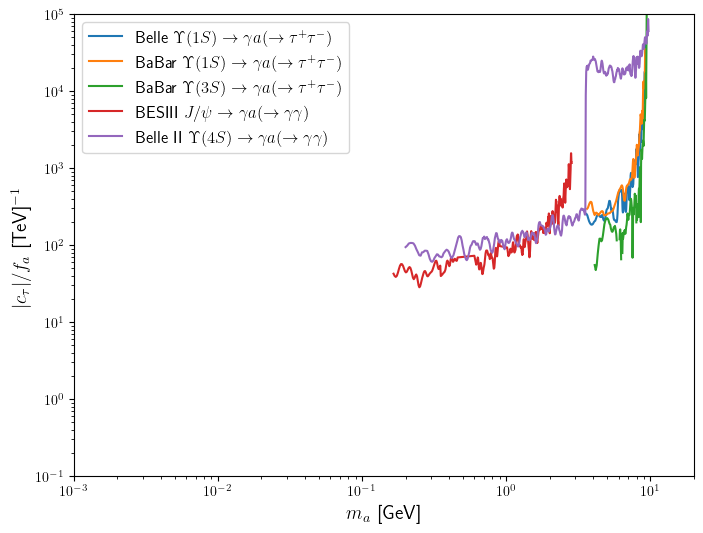

In [40]:
plt.figure(figsize=(8, 6))
plt.loglog(Belle_tautau['x'], limits_Belle_tau_tp_gg5p, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_tautau['x'], limits_BaBar_tau_tp_gg5p, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_Upsilon3S['x'], limits_BaBar_3S_tp_gg5p, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \tau^+\tau^-)$')
#plt.loglog(Belle_inv['ma_GeV'], limits_Belle_inv, label=r'Belle $\Upsilon(1S)\to \gamma + \mathrm{inv}$')
#plt.loglog(BaBar_inv['ma_GeV'], limits_BaBar_inv_gg5p, label=r'BaBar $\Upsilon(1S)\to \gamma + \mathrm{inv}$', c='tab:cyan')
#plt.loglog(BESIII_inv['ma_GeV'], limits_BESIII_inv, label=r'BESIII $J/\psi\to \gamma + \mathrm{inv}$')
plt.loglog(BESIII_photons['m_a'], limits_BESIII_photons_tp_gg5p, label=r'BESIII $J/\psi \to \gamma a(\to\gamma\gamma)$')
plt.loglog(BelleII_photons['ALPmass'], limits_BelleII_photons_tp_gg5p, label=r'Belle II $\Upsilon(4S) \to \gamma a(\to\gamma\gamma)$')
plt.xlim(1e-3, 20)
plt.ylim(1e-1, 1e5)
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)

plt.ylabel(r'$|c_\tau|/f_a$ [TeV]$^{-1}$', fontsize=14)
plt.legend(fontsize=12)

In [41]:
limits_Belle_tau_tp_gg5m = [(Belle_tautau[' y'][i]/(BR_Upsilon_gammaAlp_tp(Belle_tautau['x'][i], -5)*BR_tautau_tp(Belle_tautau['x'][i], -5)))**0.5 for i in range(len(Belle_tautau['x']))]
limits_BaBar_tau_tp_gg5m = [(BaBar_tautau[' y'][i]/(BR_Upsilon_gammaAlp_tp(BaBar_tautau['x'][i], -5)*BR_tautau_tp(BaBar_tautau['x'][i], -5)))**0.5 for i in range(len(BaBar_tautau['x']))]
limits_BaBar_3S_tp_gg5m = [(BaBar_Upsilon3S[' y'][i]/(BR_tautau_tp(BaBar_Upsilon3S['x'][i], -5)*BR_Upsilon_gammaAlp_tp(BaBar_Upsilon3S['x'][i], -5)*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
c_3S = []
for i in range(len(limits_BaBar_3S_gg5m)):
    if np.imag(limits_BaBar_3S_gg5m[i]) != 0:
        limits_BaBar_3S_gg5m[i] = float('nan')
limits_BaBar_inv_gg5m = [(BaBar_inv['BR_inv'][i]/BR_Upsilon_gammaAlp_tp(BaBar_inv['ma_GeV'][i], -5))**0.5 for i in range(len(BaBar_inv['ma_GeV']))]
for i, (m, c) in enumerate(zip(BaBar_inv['ma_GeV'], limits_BaBar_inv_gg5m)):
    if hbarc/(c**2*sum(Gamma_phi_tp(m, -5)))*1e-6 < 3:
        limits_BaBar_inv_gg5m[i] = float('nan')
limits_Belle_inv_gg5m = [(Belle_inv['BR_inv'][i]/BR_Upsilon_gammaAlp_tp(Belle_inv['ma_GeV'][i], -5))**0.5 for i in range(len(Belle_inv['ma_GeV']))]
for i, (m, c) in enumerate(zip(Belle_inv['ma_GeV'], limits_Belle_inv_gg5m)):
    if i > 0 and hbarc/(c**2*sum(Gamma_phi_tp(m, -5)))*1e-6 < 3:
        limits_Belle_inv_gg5m[i] = float('nan')
limits_BESIII_inv_gg5m = [(BESIII_inv['BR_inv'][i]/BR_Jpsi_gammaAlp_tp(BESIII_inv['ma_GeV'][i], -5))**0.5 for i in range(len(BESIII_inv['ma_GeV']))]
for i, (m, c) in enumerate(zip(BESIII_inv['ma_GeV'], limits_BESIII_inv_gg5m)):
    if hbarc/(c**2*sum(Gamma_phi_tp(m, -5)))*1e-6 < 3:
        limits_BESIII_inv_gg5m[i] = float('nan')

limits_BESIII_photons_tp_gg5m = [abs(BESIII_photons['UL_gagg'][i] * fa / Cgammagamma(BESIII_photons['m_a'][i], [mtau], -5)/BR_gg_tp(BESIII_photons['m_a'][i], -5)**0.5) for i in BESIII_photons.index]
limits_BelleII_photons_tp_gg5m = [abs(BelleII_photons['UL_gagg'][i] * fa / Cgammagamma(BelleII_photons['ALPmass'][i], [mtau], -5)/BR_gg_tp(BelleII_photons['ALPmass'][i], -5)**0.5) for i in BelleII_photons.index]

/tmp/ipykernel_17709/3006314911.py:3: RuntimeWarning: invalid value encountered in scalar power
  limits_BaBar_3S_tp_gg5m = [(BaBar_Upsilon3S[' y'][i]/(BR_tautau_tp(BaBar_Upsilon3S['x'][i], -5)*BR_Upsilon_gammaAlp_tp(BaBar_Upsilon3S['x'][i], -5)*(1+1/corr_3S)))**0.5 for i in BaBar_Upsilon3S.index]
/tmp/ipykernel_17709/1254838554.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  c += B1(4*m**2/ma**2)
/tmp/ipykernel_17709/1254838554.py:7: RuntimeWarning: invalid value encountered in scalar multiply
  B1 = lambda x: 1-x*f(x)**2


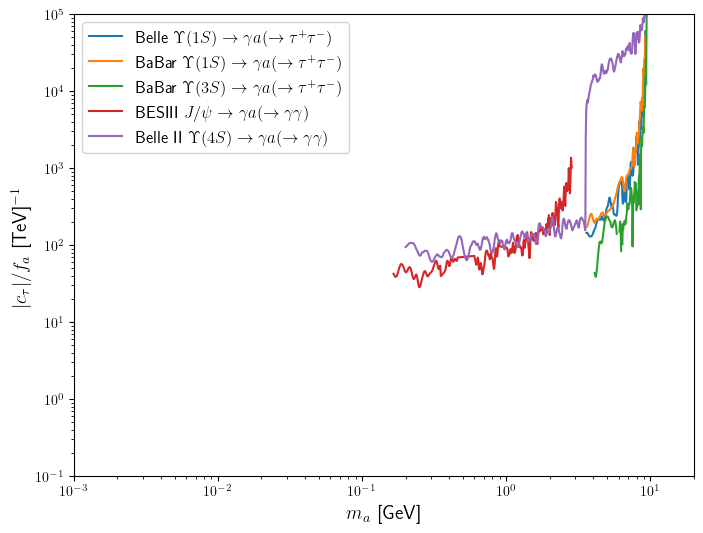

In [42]:
plt.figure(figsize=(8, 6))
plt.loglog(Belle_tautau['x'], limits_Belle_tau_tp_gg5m, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_tautau['x'], limits_BaBar_tau_tp_gg5m, label=r'BaBar $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_Upsilon3S['x'], limits_BaBar_3S_tp_gg5m, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \tau^+\tau^-)$')
#plt.loglog(Belle_inv['ma_GeV'], limits_Belle_inv_gg5m, label=r'Belle $\Upsilon(1S)\to \gamma + \mathrm{inv}$')
#plt.loglog(BaBar_inv['ma_GeV'], limits_BaBar_inv_gg5m, label=r'BaBar $\Upsilon(1S)\to \gamma + \mathrm{inv}$', c='tab:cyan')
#plt.loglog(BESIII_inv['ma_GeV'], limits_BESIII_inv_gg5m, label=r'BESIII $J/\psi\to \gamma + \mathrm{inv}$', c='tab:cyan')
plt.loglog(BESIII_photons['m_a'], limits_BESIII_photons_tp_gg5m, label=r'BESIII $J/\psi \to \gamma a(\to\gamma\gamma)$')
plt.loglog(BelleII_photons['ALPmass'], limits_BelleII_photons_tp_gg5m, label=r'Belle II $\Upsilon(4S) \to \gamma a(\to\gamma\gamma)$')
plt.xlim(1e-3, 20)
plt.ylim(1e-1, 1e5)
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)

plt.ylabel(r'$|c_\tau|/f_a$ [TeV]$^{-1}$', fontsize=14)
plt.legend(fontsize=12)

In [43]:
pd.DataFrame({'ma_GeV': BelleII_photons['ALPmass'], 'cl+gg0': limits_BelleII_photons_tp_gg5p, 'cl-gg0': limits_BelleII_photons_tp_gg5m}).to_csv('../data/quarkonia/BelleII_Y4S3g_tau_cgg.csv', index=False)
pd.DataFrame({'ma_GeV': BaBar_Upsilon3S['x'], 'cl+gg0': limits_BaBar_3S_tp_gg5p, 'cl-gg0': limits_BaBar_3S_tp_gg5m, }).to_csv('../data/quarkonia/BaBar_Y3Stautau_tp_cgg.csv', index=False)

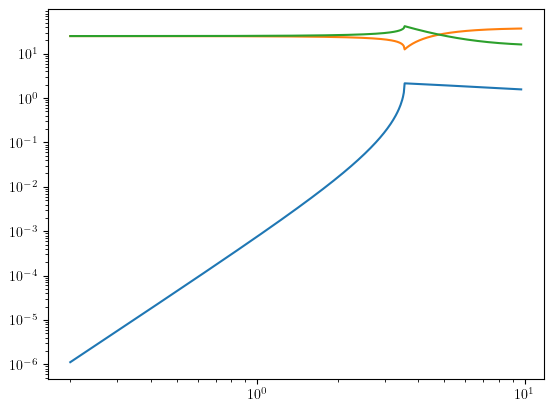

In [44]:
plt.loglog(BelleII_photons['ALPmass'], [abs(np.pi/alpha_em*Cgammagamma(ma, [mtau]))**2 for ma in BelleII_photons['ALPmass']])
plt.loglog(BelleII_photons['ALPmass'], [abs(np.pi/alpha_em*Cgammagamma(ma, [mtau], 5))**2 for ma in BelleII_photons['ALPmass']])
plt.loglog(BelleII_photons['ALPmass'], [abs(np.pi/alpha_em*Cgammagamma(ma, [mtau], -5))**2 for ma in BelleII_photons['ALPmass']])

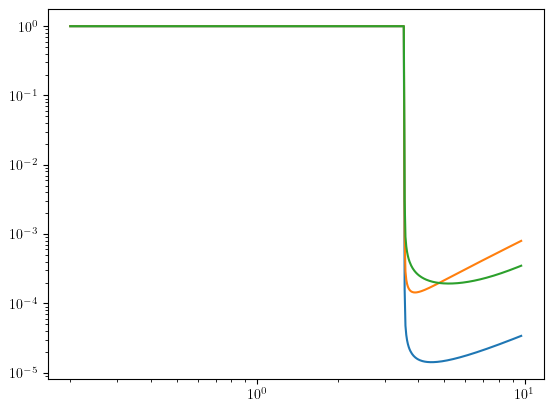

In [45]:
plt.loglog(BelleII_photons['ALPmass'], [BR_gg_tp(ma) for ma in BelleII_photons['ALPmass']])
plt.loglog(BelleII_photons['ALPmass'], [BR_gg_tp(ma, 5) for ma in BelleII_photons['ALPmass']])
plt.loglog(BelleII_photons['ALPmass'], [BR_gg_tp(ma, -5) for ma in BelleII_photons['ALPmass']]) 

In [46]:
(2/1.644)**0.5

1.102970993347264